# Analysis of active TFs by convolving PWMs with deepLIFT scores

1. Load TF PWMs (HOMER should be a good enough set)
2. Load train sequences
3. Load deepLIFT scores
4. Compute PWM-deepLIFT and PWM-sequence convolution matrices using Avanti's GPU accelerated function:
https://github.com/kundajelab/modisco_private/blob/master/test/util/test_correlation.py
5. Divide the two matrices to "normalize" the PWM-deepLIFT convolution matrix. That is, the matrix entries now represent how much the motif was used by the model in making a prediction.
6. Visualize average motif usage by chromatin state.
7. Create a motif-motif correlation matrix to see which motifs were predictive together. Cluster this matrix to reproduce known TF interactions.

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import glob
import time
from collections import OrderedDict

motifpwms = OrderedDict()

homer_path = '../../data/motifs/homer/*.motif'
t0 = time.time()
for homer_file in glob.glob(homer_path):
    with open(homer_file) as f:
        header = f.readline().strip().split('\t')
        name = header[1]
        threshold = float(header[2])
        weights = np.array(pd.read_csv(f, sep = '\t'))
        motifpwms[name] = weights
print("Took %.3f sec to load HOMER motifs" % (time.time() - t0))

print("Number of PWMs: %d" % len(motifpwms))

Took 1.516 sec to load HOMER motifs
Number of PWMs: 344


In [4]:
import h5py

train_data_path = '../hdf5files/sharpr_znormed_jul23/train_data.hdf5'
data = h5py.File(train_data_path)

data_X = np.array(data['X/sequence'])
data_Y = np.array(data['Y/output'])

In [5]:
labels = np.array(data_Y[:, 2])[::2]

In [6]:
from collections import OrderedDict

modelName = "record_13_model_bgGhy_" 

task_to_deeplift_contribs = OrderedDict()
t0 = time.time()
# for task_idx in [2, 5, 8, 11]:
for task_idx in [2]:
    path = '../deeplift_scores/%s/contribs_reshaped_task%d.tab' % (modelName[:-1], task_idx)
    task_to_deeplift_contribs[task_idx] = pd.read_csv(path, 
                                                      sep = '\t',
                                                      header = None).values
    task_to_deeplift_contribs[task_idx] = task_to_deeplift_contribs[task_idx][:, 1:]
    print task_to_deeplift_contribs[task_idx].shape
    task_to_deeplift_contribs[task_idx] = np.reshape(task_to_deeplift_contribs[task_idx], (-1, 145, 4))
    print("Reading in deepLIFT scores for task %d took %.3f sec" % (task_idx, time.time() - t0))
    t0 = time.time()
    
# Use summed sequence scores instead of multipliers

task_to_deeplift_summedscores = OrderedDict()
for task_idx in task_to_deeplift_contribs:
    summed_scores = np.sum(task_to_deeplift_contribs[task_idx], axis=2)
    task_to_deeplift_summedscores[task_idx] = np.expand_dims(summed_scores, axis=2)*data_X

(914348, 580)
Reading in deepLIFT scores for task 2 took 728.955 sec


In [48]:
# Save deepLIFT contribs and filter PWMs as .npy for Avanti

np.save('../deeplift_scores/record_13_model_bgGhy/forAvanti/deepLiftMultipliers_bgGhy.npy',
        task_to_deeplift_summedscores[2])

np.save('../deeplift_scores/record_13_model_bgGhy/forAvanti/homer_pwms_344.npy',
        pwmArray)

np.savetxt('../deeplift_scores/record_13_model_bgGhy/forAvanti/pwm_names.txt',
           motifnames,
           fmt = '%s',
           comments = '')

[124738]
4.1682


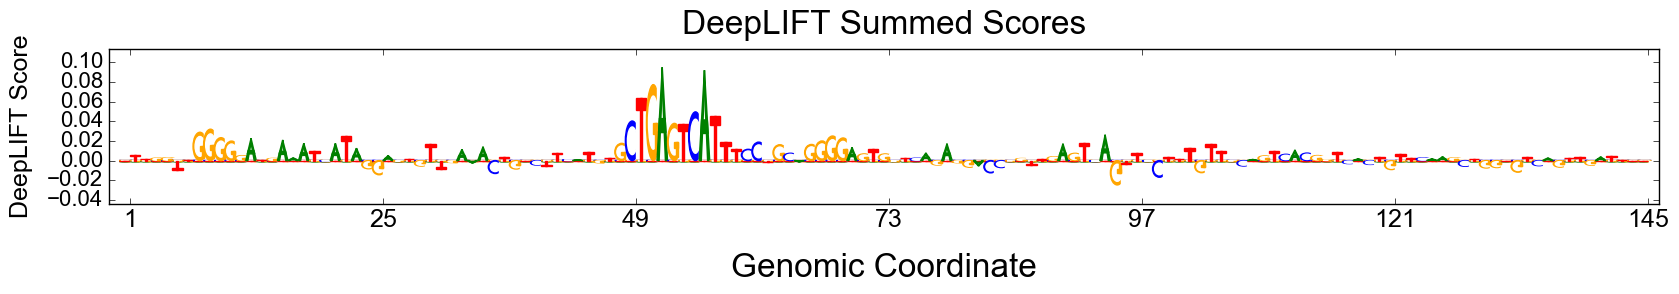

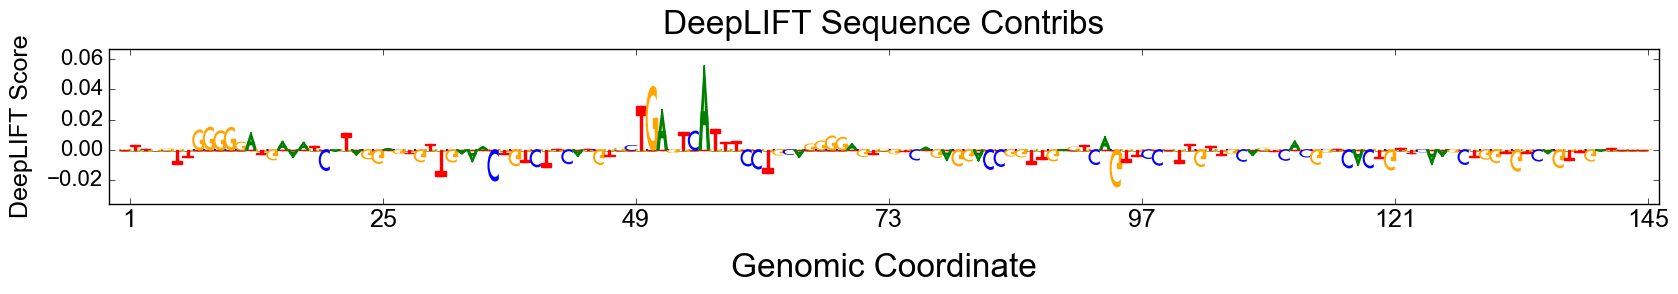

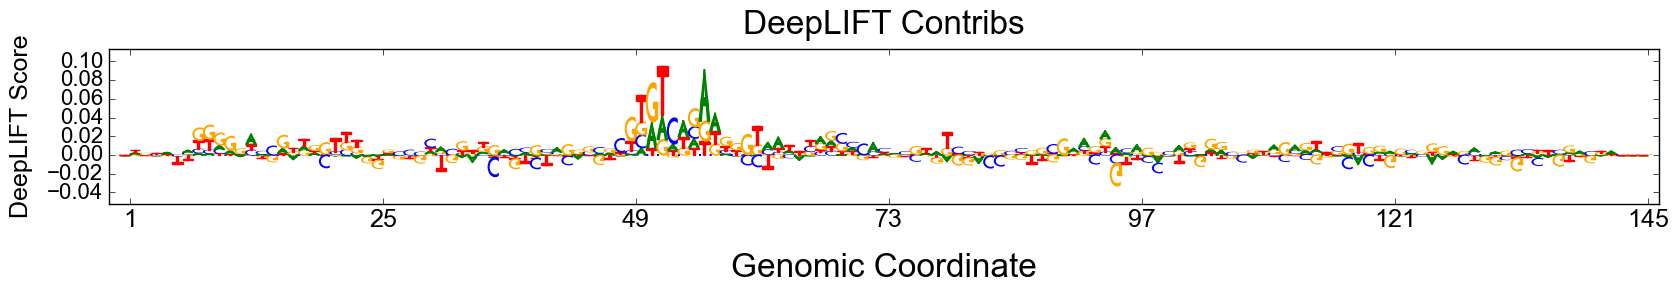

In [32]:
from deeplift.visualization import viz_sequence

idxs = np.argsort(labels)[::-1][20:21]
print idxs

for idx in idxs:
    print labels[idx]
    viz_sequence.plot_weights(task_to_deeplift_summedscores[2][2*idx],
                              tickcount = 6,
                              figsize = (20, 2),
                              xlabel = 'Genomic Coordinate',
    #                           start_coord = start_coord,
                              xtickfontsize = 18,
                              title = 'DeepLIFT Summed Scores'
                             )
    viz_sequence.plot_weights(task_to_deeplift_contribs[2][idx]*data_X[2*idx],
                              tickcount = 6,
                              figsize = (20, 2),
                              xlabel = 'Genomic Coordinate',
    #                           start_coord = start_coord,
                              xtickfontsize = 18,
                              title = 'DeepLIFT Sequence Contribs'
                             )
    viz_sequence.plot_weights(task_to_deeplift_contribs[2][idx],
                              tickcount = 6,
                              figsize = (20, 2),
                              xlabel = 'Genomic Coordinate',
#                               start_coord = 1,
                              xtickfontsize = 18,
                              title = 'DeepLIFT Contribs'
                             )

In [8]:
# Convert shape to 2D image-like for convolution function
# Update 31 Aug - removing the image-like conversion b/c the cosine distance function that
# Avanti implemented accepts samples x length x channels (ACGT)

for task_idx in task_to_deeplift_contribs:
    # notice that the first line uses summedscores, not contribs, just didn't want to change names everywhere
    task_to_deeplift_contribs[task_idx] = task_to_deeplift_contribs[task_idx][::2].astype(np.float32)
#     task_to_deeplift_contribs[task_idx] = np.swapaxes(task_to_deeplift_contribs[task_idx], 1, 2)
#     task_to_deeplift_contribs[task_idx] = np.expand_dims(task_to_deeplift_contribs[task_idx], axis = 1)
    
print task_to_deeplift_contribs[2].shape

(457174, 145, 4)


In [9]:
maxPwmLen = np.max([pwm.shape[0] for pwm in motifpwms.values()])
pwmArray = np.ndarray(shape = (len(motifpwms), 4, maxPwmLen), dtype = np.float32)
for (i, pwm) in enumerate(motifpwms.values()):
    if pwm.shape[0] < maxPwmLen:
        padLen = maxPwmLen - pwm.shape[0]
        padded_pwm = np.concatenate((np.zeros((padLen/2, 4)), pwm, np.zeros((padLen/2, 4))))
        if padded_pwm.shape[0] < maxPwmLen:
            padded_pwm = np.concatenate((padded_pwm, np.zeros((1, 4))))
        pwmArray[i] = np.swapaxes(padded_pwm, 0, 1).astype(np.float32)
    else:
        pwmArray[i] = np.swapaxes(pwm, 0, 1).astype(np.float32)

In [10]:
print pwmArray.shape

(344, 4, 24)


In [11]:
print np.mean(task_to_deeplift_contribs[2])
print np.mean(pwmArray)

0.000193494
0.117342


In [12]:
print pwmArray.shape
print task_to_deeplift_contribs[task_idx].shape
print data_X.shape

(344, 4, 24)
(457174, 145, 4)
(914348, 145, 4)


In [13]:
import sys
import os
import numpy as np
import modisco
import modisco.util
import time

print task_to_deeplift_contribs[2].shape
print pwmArray.shape

task_idxs = [2, 5, 8, 11]
convMatrices = np.ndarray((len(task_idxs), task_to_deeplift_contribs[2].shape[0], pwmArray.shape[0]), dtype=np.float32)

t0 = time.time()
for (i, task_idx) in enumerate([2]):
    print("On task %d" % task_idx)
    chunkLen = 50000
    for seqStart in range(0, convMatrices.shape[1], chunkLen):
#     for seqStart in range(400000, convMatrices.shape[1], chunkLen):
        seqEnd = min(seqStart + chunkLen, convMatrices.shape[1])
        print("On sequences %d to %d" % (seqStart, seqEnd))
#         convScan = np.array(modisco.util.scan_regions_with_filters(
#                            filters=pwmArray, 
#                            regions_to_scan=task_to_deeplift_contribs[task_idx][seqStart : seqEnd],
#                            progress_update=None)
#                            ).astype(np.float32)
        convScan = np.array(modisco.util.product_of_cosine_distances(
                           filters=pwmArray, 
                           track1=task_to_deeplift_contribs[task_idx][seqStart : seqEnd],
                           track2=data_X[seqStart : seqEnd],
                           batch_size=200,
                           progress_update=None)
                           ).astype(np.float32)
#         print convScan.shape
        convScan = convScan[:, :, 0:1, :]
#         print convScan.shape
#         print np.mean(convScan)
#         print convScan.shape
#         print np.max(convScan, axis=(2, 3)).shape
#         print np.mean()
        convMatrices[i, seqStart : seqEnd] = np.max(convScan, axis=(2, 3))
#         sys.exit(0)
    print("Computing conv matrix for task %d took %.3f sec" % (task_idx, time.time() - t0))
    t0 = time.time()
#     print("Computing max convolutions for task %d took %.3f" % (task_idx, time.time() - t0))
#     t0 = time.time()

(457174, 145, 4)
(344, 4, 24)
On task 2
On sequences 0 to 50000
On sequences 50000 to 100000
On sequences 100000 to 150000
On sequences 150000 to 200000
On sequences 200000 to 250000
On sequences 250000 to 300000
On sequences 300000 to 350000
On sequences 350000 to 400000
On sequences 400000 to 450000
On sequences 450000 to 457174
Computing conv matrix for task 2 took 765.769 sec


In [29]:
# Get background motif occurrence

data_X_reformat = data_X[::2].astype(np.float32)
data_X_reformat = np.swapaxes(data_X_reformat, 1, 2)
data_X_reformat = np.expand_dims(data_X_reformat, axis = 1)
    
print data_X_reformat.shape
print pwmArray.shape

backgroundMotifPresence = np.ndarray((data_X_reformat.shape[0], pwmArray.shape[0]), dtype=np.float32)

t0 = time.time()
chunkLen = 50000
for seqStart in range(0, backgroundMotifPresence.shape[0], chunkLen):
    seqEnd = min(seqStart + chunkLen, backgroundMotifPresence.shape[0])
    print("On sequences %d to %d" % (seqStart, seqEnd))
    convScan = np.array(modisco.util.scan_regions_with_filters(
                       filters=pwmArray, 
                       regions_to_scan=data_X_reformat[seqStart : seqEnd],
                       progress_update=None)
                       ).astype(np.float32)
    convScan = convScan[:, :, 0:1, :]
    backgroundMotifPresence[seqStart : seqEnd] = np.max(convScan, axis=(2, 3))
print("Computing PWM-sequence motif conv matrix took %.3f sec" % (time.time() - t0))

(457174, 1, 4, 145)
(344, 4, 24)
On sequences 0 to 50000
On sequences 50000 to 100000
On sequences 100000 to 150000
On sequences 150000 to 200000
On sequences 200000 to 250000
On sequences 250000 to 300000
On sequences 300000 to 350000
On sequences 350000 to 400000
On sequences 400000 to 450000
On sequences 450000 to 457174
Computing PWM-sequence motif conv matrix took 759.929 sec


In [14]:
import pandas as pd

modelName = "record_13_model_bgGhy_"
    
t0 = time.time()
for (i, task_idx) in enumerate([2]):
    df = pd.DataFrame(convMatrices[i])
    df.to_csv("../deeplift_scores/%s/pwm_deepliftmultipliers_convmatrix_task%d.tab" % (modelName[:-1], task_idx),
              sep = '\t',
              header = False,
              index = False
             )
    print("Writing PWM deeplift multiplier cosine distance product scores for task %d took %.3f sec" % (task_idx, time.time() - t0))
    t0 = time.time()
    
# df = pd.DataFrame(backgroundMotifPresence)
# df.to_csv("../deeplift_scores/pwm_sequence_convmatrix_backgroundmotifs.tab",
#               sep = '\t',
#               header = False,
#               index = False
#              )
# print("Writing background motif scores took %.3f sec" % (time.time() - t0))

Writing PWM deeplift multiplier cosine distance product scores for task 2 took 70.189 sec


In [45]:
import pandas as pd

modelName = "record_13_model_bgGhy_"

# task_idxs = [2,5,8,11]
# convMatrices = np.ndarray((len(task_idxs), task_to_deeplift_contribs[2].shape[0], pwmArray.shape[0]), dtype=np.float32)

# t0 = time.time()
# for (i, task_idx) in enumerate([2]):
#     path = "../deeplift_scores/%s/pwm_summeddeeplift_convmatrix_task%d.tab" % (modelName[:-1], task_idx)
#     convMatrices[i] = pd.read_csv(path, 
#                                   sep = '\t',
#                                   header = None,
#                                   index_col = False).values
#     print("Reading in PWM-summed deeplift convolution scores for task %d took %.3f sec" % (task_idx, time.time() - t0))
#     t0 = time.time()
    
path = "../deeplift_scores/pwm_sequence_convmatrix_backgroundmotifs.tab"
backgroundMotifPresence = pd.read_csv(path, 
                                      sep = '\t',
                                      header = None,
                                      index_col = False).values.astype(np.float32)
print("Reading in background motif scores for task %d took %.3f sec" % (task_idx, time.time() - t0))
t0 = time.time()

Reading in background motif scores for task 2 took 29.459 sec


In [40]:
motif = "AP1"
for (i, key) in enumerate(motifpwms.keys()):
    if key.find(motif) != -1:
        motif_idx = i
        break

print motif_idx
print motifpwms.keys()[motif_idx]

print convMatrices[0][114772][motif_idx]

67
CEBP:AP1(bZIP)/ThioMac-CEBPb-ChIP-Seq(GSE21512)/Homer
0.119208


In [16]:
print np.mean(convMatrices[0][114772])

0.140281


In [41]:
motifnames = np.array(motifpwms.keys())

seq_idx = 124738

print np.sort(convMatrices[0][seq_idx])[::-1][:20]
print motifnames[np.argsort(convMatrices[0][seq_idx])[::-1][:20]]

print convMatrices[0][seq_idx][67]

[ 0.22094543  0.21452343  0.2129932   0.2116922   0.21166578  0.20819247
  0.20428392  0.20367803  0.20277043  0.20270547  0.20243371  0.20012586
  0.19885501  0.19804759  0.19696394  0.19310907  0.19308071  0.19272733
  0.1925844   0.19185351]
['Zic3(Zf)/mES-Zic3-ChIP-Seq(GSE37889)/Homer'
 'REST-NRSF(Zf)/Jurkat-NRSF-ChIP-Seq/Homer'
 'Mouse_Recombination_Hotspot(Zf)/Testis-DMC1-ChIP-Seq(GSE24438)/Homer'
 'ARE(NR)/LNCAP-AR-ChIP-Seq(GSE27824)/Homer'
 'Brachyury(T-box)/Mesoendoderm-Brachyury-ChIP-exo(GSE54963)/Homer'
 'ZNF41(Zf)/HEK293-ZNF41.GFP-ChIP-Seq(GSE58341)/Homer'
 'OCT4-SOX2-TCF-NANOG(POU,Homeobox,HMG)/mES-Oct4-ChIP-Seq(GSE11431)/Homer'
 'CEBP:CEBP(bZIP)/MEF-Chop-ChIP-Seq(GSE35681)/Homer'
 'Rfx2(HTH)/LoVo-RFX2-ChIP-Seq(GSE49402)/Homer'
 'ZNF136(Zf)/HEK293-ZNF136.GFP-ChIP-Seq(GSE58341)/Homer'
 'PAX5(Paired,Homeobox),condensed/GM12878-PAX5-ChIP-Seq(GSE32465)/Homer'
 'HNF4a(NR),DR1/HepG2-HNF4a-ChIP-Seq(GSE25021)/Homer'
 'ZNF322(Zf)/HEK293-ZNF322.GFP-ChIP-Seq(GSE58341)/Homer'
 'GATA:S

In [33]:
normalizedMotifMatrices = np.ndarray((len(task_idxs), 
                                      task_to_deeplift_contribs[2].shape[0], 
                                      pwmArray.shape[0]), 
                                     dtype=np.float32)

# Some motifs might just have higher average PWM*sequence scores
# To get an accurate view of motif usage, need to divide by mean(PWM*sequence).
# That way, the denominator represents how much MORE the motif is showing up in that sequence
# Now that I think about it, some motifs might also have hgiher PWM*deepLIFT scores b/c the PWM is longer
# So the PWM*deepLIFT also needs to be normalized by mean(PWM*deepLIFT) for each motif
normalizedConvMatrices = np.ndarray((len(task_idxs), task_to_deeplift_contribs[2].shape[0], pwmArray.shape[0]), dtype=np.float32)
for (i, task_idx) in enumerate([2]):
    normalizedConvMatrices[i] = convMatrices[i] / np.mean(convMatrices[i], axis=0)
normalizedBackgroundMotifPresence = backgroundMotifPresence / np.mean(backgroundMotifPresence, axis=0)

for (i, task_idx) in enumerate([2]):
    normalizedMotifMatrices[i] = normalizedConvMatrices[i] / normalizedBackgroundMotifPresence

In [34]:
print np.mean(normalizedConvMatrices[0]), np.std(normalizedConvMatrices[0])
print np.mean(normalizedBackgroundMotifPresence), np.std(normalizedBackgroundMotifPresence)
print np.mean(normalizedMotifMatrices[0]), np.std(normalizedMotifMatrices[0])

1.0 0.422011
1.00001 0.0908308
1.00893 0.440956


In [35]:
motif = "AP1"
for (i, key) in enumerate(motifpwms.keys()):
    if key.find(motif) != -1:
        motif_idx = i
        break

print motif_idx
        
print motifpwms.keys()[motif_idx]

print np.mean(normalizedConvMatrices[0][:, motif_idx]), np.std(normalizedConvMatrices[0][:, motif_idx])
print np.mean(normalizedBackgroundMotifPresence[:, motif_idx]), np.std(normalizedBackgroundMotifPresence[:, motif_idx])

from scipy.stats import spearmanr

print spearmanr(labels, normalizedConvMatrices[0][:, motif_idx])
print spearmanr(labels, normalizedBackgroundMotifPresence[:, motif_idx])

67
CEBP:AP1(bZIP)/ThioMac-CEBPb-ChIP-Seq(GSE21512)/Homer
1.0 0.427432
1.00005 0.0901592
SpearmanrResult(correlation=0.14516505673841609, pvalue=0.0)
SpearmanrResult(correlation=-0.010472885945265766, pvalue=1.4272664914073747e-12)


In [51]:
print spearmanr(labels, np.mean(task_to_deeplift_contribs[2], axis=(1,2,3)))

SpearmanrResult(correlation=0.18029639488759516, pvalue=0.0)


In [36]:
deeplift_motifpresence_corrs = []
t0 = time.time()
for motif_idx in range(convMatrices[0].shape[1]):
    if motif_idx % 50 == 0 and motif_idx > 0:
        print("Correlating motifs %d to %d took %.3f sec" % (motif_idx - 50, motif_idx, time.time() - t0))
        t0 = time.time()
    deeplift_motifpresence_corrs.append(spearmanr(convMatrices[0][:, motif_idx], backgroundMotifPresence[:, motif_idx])[0])

print np.mean(deeplift_motifpresence_corrs), np.std(deeplift_motifpresence_corrs)

Correlating motifs 0 to 50 took 5.539 sec
Correlating motifs 50 to 100 took 5.619 sec
Correlating motifs 100 to 150 took 5.497 sec
Correlating motifs 150 to 200 took 5.576 sec
Correlating motifs 200 to 250 took 5.476 sec
Correlating motifs 250 to 300 took 5.568 sec
-0.0104028582026 0.102931076546


In [37]:
print np.array(deeplift_motifpresence_corrs)[np.argsort(np.abs(deeplift_motifpresence_corrs))[::-1][:30]]
print np.array(motifpwms.keys())[np.argsort(np.abs(deeplift_motifpresence_corrs))[::-1][:30]]

[ 0.27938014  0.27414011  0.27038558  0.26815696  0.24999643  0.24066577
  0.24017536  0.23774721  0.23473919  0.23227547  0.21120002  0.2087642
  0.20545857  0.19518362  0.19163061  0.18912563 -0.18729675  0.18667145
  0.18507818  0.18131324  0.17458052  0.17361039 -0.17235199 -0.17132375
 -0.17058162  0.17032848  0.16870795  0.16738989  0.16708903  0.1656519 ]
['Sp1(Zf)/Promoter/Homer' 'Sp5(Zf)/mES-Sp5.Flag-ChIP-Seq(GSE72989)/Homer'
 'Maz(Zf)/HepG2-Maz-ChIP-Seq(GSE31477)/Homer'
 'KLF14(Zf)/HEK293-KLF14.GFP-ChIP-Seq(GSE58341)/Homer'
 'KLF5(Zf)/LoVo-KLF5-ChIP-Seq(GSE49402)/Homer'
 'KLF3(Zf)/MEF-Klf3-ChIP-Seq(GSE44748)/Homer'
 'Egr2(Zf)/Thymocytes-Egr2-ChIP-Seq(GSE34254)/Homer'
 'Egr1(Zf)/K562-Egr1-ChIP-Seq(GSE32465)/Homer'
 'KLF6(Zf)/PDAC-KLF6-ChIP-Seq(GSE64557)/Homer'
 'Klf9(Zf)/GBM-Klf9-ChIP-Seq(GSE62211)/Homer'
 'ZNF467(Zf)/HEK293-ZNF467.GFP-ChIP-Seq(GSE58341)/Homer'
 'Elk1(ETS)/Hela-Elk1-ChIP-Seq(GSE31477)/Homer'
 'ELF1(ETS)/Jurkat-ELF1-ChIP-Seq(SRA014231)/Homer'
 'Elk4(ETS)/Hela-E

In [22]:
topN = 30
topSeqs = len(labels)
topSeqs = 10000
topSeqIdxs = np.argsort(labels)[::-1][:topSeqs]

pwmLens = np.array([pwm.shape[0] for pwm in motifpwms.values()])

print "Max sum deepLIFT - PWM scores"
topMotifIdxs = np.argsort(np.sum(convMatrices[0], axis=0) / pwmLens)[::-1][:topN]
print np.array(motifpwms.keys())[topMotifIdxs]
print (np.sum(convMatrices[0], axis=0) / pwmLens)[topMotifIdxs]

# print "Max sum deepLIFT / avg ratios"
# topMotifIdxs = np.argsort(np.sum(normalizedConvMatrices[0], axis=0))[::-1][:topN]
# print np.array(motifpwms.keys())[topMotifIdxs]
# print np.sum(normalizedConvMatrices[0], axis=0)[topMotifIdxs]

# print "Max background motif presence"
# topMotifIdxs = np.argsort(np.sum(normalizedBackgroundMotifPresence, axis=0))[::-1][:topN]
# print np.array(motifpwms.keys())[topMotifIdxs]

# print "Max normalized motif usage (deepLIFT / background)"
# topMotifIdxs = np.argsort(np.sum(normalizedMotifMatrices[0], axis=0))[::-1][:topN]
# print np.array(motifpwms.keys())[topMotifIdxs]
# print np.sum(normalizedMotifMatrices[0][topMotifIdxs], axis=0)[:topN]

# print "Max normalized motif usage (deepLIFT / background)"
# topMotifIdxs = np.argsort(np.sum(convMatrices[0], axis=0) / np.sum(backgroundMotifPresence, axis=0))[::-1]
# print np.array(motifpwms.keys())[topMotifIdxs[:topN]]

Max sum deepLIFT - PWM scores
['Tgif2(Homeobox)/mES-Tgif2-ChIP-Seq(GSE55404)/Homer'
 'SCL(bHLH)/HPC7-Scl-ChIP-Seq(GSE13511)/Homer'
 'Pitx1(Homeobox)/Chicken-Pitx1-ChIP-Seq(GSE38910)/Homer'
 'Smad3(MAD)/NPC-Smad3-ChIP-Seq(GSE36673)/Homer'
 'Tbx5(T-box)/HL1-Tbx5.biotin-ChIP-Seq(GSE21529)/Homer'
 'Tgif1(Homeobox)/mES-Tgif1-ChIP-Seq(GSE55404)/Homer'
 'Smad2(MAD)/ES-SMAD2-ChIP-Seq(GSE29422)/Homer'
 'THRb(NR)/Liver-NR1A2-ChIP-Seq(GSE52613)/Homer'
 'Maz(Zf)/HepG2-Maz-ChIP-Seq(GSE31477)/Homer'
 'SF1(NR)/H295R-Nr5a1-ChIP-Seq(GSE44220)/Homer'
 'Sox3(HMG)/NPC-Sox3-ChIP-Seq(GSE33059)/Homer'
 'COUP-TFII(NR)/Artia-Nr2f2-ChIP-Seq(GSE46497)/Homer'
 'ZNF711(Zf)/SHSY5Y-ZNF711-ChIP-Seq(GSE20673)/Homer'
 'ZFX(Zf)/mES-Zfx-ChIP-Seq(GSE11431)/Homer'
 'HEB(bHLH)/mES-Heb-ChIP-Seq(GSE53233)/Homer'
 'Fli1(ETS)/CD8-FLI-ChIP-Seq(GSE20898)/Homer'
 'MYB(HTH)/ERMYB-Myb-ChIPSeq(GSE22095)/Homer'
 'HIF-1b(HLH)/T47D-HIF1b-ChIP-Seq(GSE59937)/Homer'
 'NF1-halfsite(CTF)/LNCaP-NF1-ChIP-Seq(Unpublished)/Homer'
 'HIF-1a(bHLH)/

In [ ]:
motifFamilies = [['bZIP'], ['bHLH', 'HLH'], ['Zf', 'ZNF', 'THAP'], ['']  

#create a color palette with the same number of colors as unique values in the Source column
network_pal = sns.light_palette('red', len(df.Source.unique()))

#Create a dictionary where the key is the category and the values are the
#colors from the palette we just created
network_lut = dict(zip(df.Source.unique(), network_pal))

#get the series of all of the categories
networks = df.Source

#map the colors to the series. Now we have a list of colors the same
#length as our dataframe, where unique values are mapped to the same color
network_colors = pd.Series(networks).map(network_lut)

#plot the heatmap with the 16S and ITS categories with the network colors
#defined by Source column
sns.clustermap(df[['16S', 'ITS']], row_colors=network_colors, cmap='BuGn_r')

In [239]:
# corrMatMotifIdxs = np.argsort(np.sum(normalizedConvMatrices[0], axis=0))[::-1][:344]
homerTfs = ['ETS', 'NFY', 'AP1', 'bZIP', 'Sp', 'Atf', 'ATF', 
            'NRF', 'Promoter', 'Jun', 'GFX', 'GFY', 'KLF', 'Klf',
            'HLH', 'ZBTB33', 'CRE', 'YY1', 'ZNF143', 'RUNX',
            'GATA', 'JUN', 'Stat', 'MafB', 'IRF', 'SpiB', 'CEBP', 'Maz',
           ]
homerTfs = ['ETS', 'NFY', 'AP1', 'Sp', 'Atf', 'NRF', 
            'YY1', 'KLF', 'GATA', 'RUNX',
            'CTCF', 'REST', 
           ]
homerTfs = ['ETS', 'Sp', 'KLF', 'YY1', 'NFY', 'NRF', 'CTCF', 'REST']
#             'NRF', 'Promoter', 'Jun', 'GFY', 'KLF', 'Klf',
#             'ZBTB33', 'CRE', 'YY1', 'ZNF143', 'RUNX',
#             'GATA', 'JUN', 'Stat', 'MafB', 'IRF', 'SpiB',
#            ]
idxs = []
for (i, tf) in enumerate(motifpwms.keys()):
    for curatedTf in homerTfs:
        if tf.find(curatedTf) != -1:
            idxs.append(i)
            continue
corrMatMotifIdxs = np.array(list(set(idxs)))

In [39]:
import gzip

names = gzip.open('../splits/sharpr_znormed_jul23/train_split.txt.gz', 'rb').readlines()
names = [names[i].strip()[:-2] for i in range(len(names)) if i%2 == 0]

In [40]:
df = pd.DataFrame(normalizedConvMatrices[0])
df.index = names
df.columns = motifpwms.keys()

## TF predictiveness by chromatin state

In [235]:
# Class 01 Tss Active Promoter
# Class 02 TssF Active Promoter
# Class 03 PromF Promoter Flanking
# Class 04 PromP Promoter Poised
# Class 05 Enh Strong Enhncer
# Class 06 EnhF Strong Enhancer F
# Class 07 EnhW Weak Enhancer
# Class 08 EnhWF Enhancer Poised or Weak
# Class 09 DnaseU DNase UW
# Class 10 DnaseD DNase Duke
# Class 11 FaireW Modest FAIRE
# Class 12 CtcfO Distal CTCF Chrom
# Class 13 Ctcf Distal CTCF NoChrom
# Class 14 Gen5 Transcription transition
# Class 15 Elon Transcription elongation
# Class 16 ElonW Transcription elongation - weak
# Class 17 Gen3 Transcription elongation - 3' end
# Class 18 Pol2 Transcription Pol2
# Class 19 H4K20 Transcription intronic
# Class 20 ReprD Polycomb Repressed - Conserved
# Class 21 Repr Polycomb Repressed
# Class 22 ReprW Polycomb Repressed - Weak
# Class 23 Low Low Signal
# Class 24 Quies Hetrochromatin
# Class 25 Art Repeats CNV's, artifacts
# Class 26 Null No Class provided
states_to_compare = [[1,2,3,4], [14, 15, 18], [5], [9,10], [12,13], [20, 21, 22]]
state_names = ['Promoter', 'Transcribed', 'Enhancer', 'DNase', 'CTCF', 'Repressed']
# states_to_compare = [[1,2], [5]]
# state_names = ['Promoter', 'Enhancer']

state_idxs = []
for (i, state) in enumerate(states_to_compare):
    state_idxs.append([])
    for (idx, fragment) in enumerate(np.array(df.index)):
        if fragment.split('_')[0] != 'K562':
            continue
        if int(fragment.split('_')[1]) in state:
            state_idxs[i].append(idx)
            
for (i, state) in enumerate(state_names):
    print("%s: %d" % (state_names[i], len(state_idxs[i])))

Promoter: 14904
Transcribed: 5115
Enhancer: 34896
DNase: 12676
CTCF: 14468
Repressed: 2666


In [211]:
valsByState = []
for state in state_idxs:
    valsByState.append(np.mean(df.iloc[state], axis = 0))
    
valsByState = np.array(valsByState)

df_states = pd.DataFrame(data = np.transpose(valsByState),
                         index = df.columns,
                         columns = state_names)
df_states = df_states.iloc[corrMatMotifIdxs]

df_states_sorted = df_states.iloc[np.argsort(np.array(df_states['Promoter'] / df_states['Enhancer']))[::-1]]

In [240]:
deeplift_corr_data = []
for (i, tf) in enumerate(df.columns):
    if i % 50 == 0:
        print i
    deeplift_corr_data.append([])
    for (j, state) in enumerate(state_idxs):
        deeplift_corr_data[i].append(spearmanr(df[tf].iloc[state], backgroundMotifPresence[state, i])[0])
        
deeplift_corr_data = np.array(deeplift_corr_data)
print deeplift_corr_data.shape
deeplift_corr_df = pd.DataFrame(data = deeplift_corr_data,
                                index = df.columns,
                                columns = state_names)

deeplift_corr_df = deeplift_corr_df.iloc[corrMatMotifIdxs]
print deeplift_corr_df.values.shape

0
50
100
150
200
250
300
(344, 6)
(39, 6)


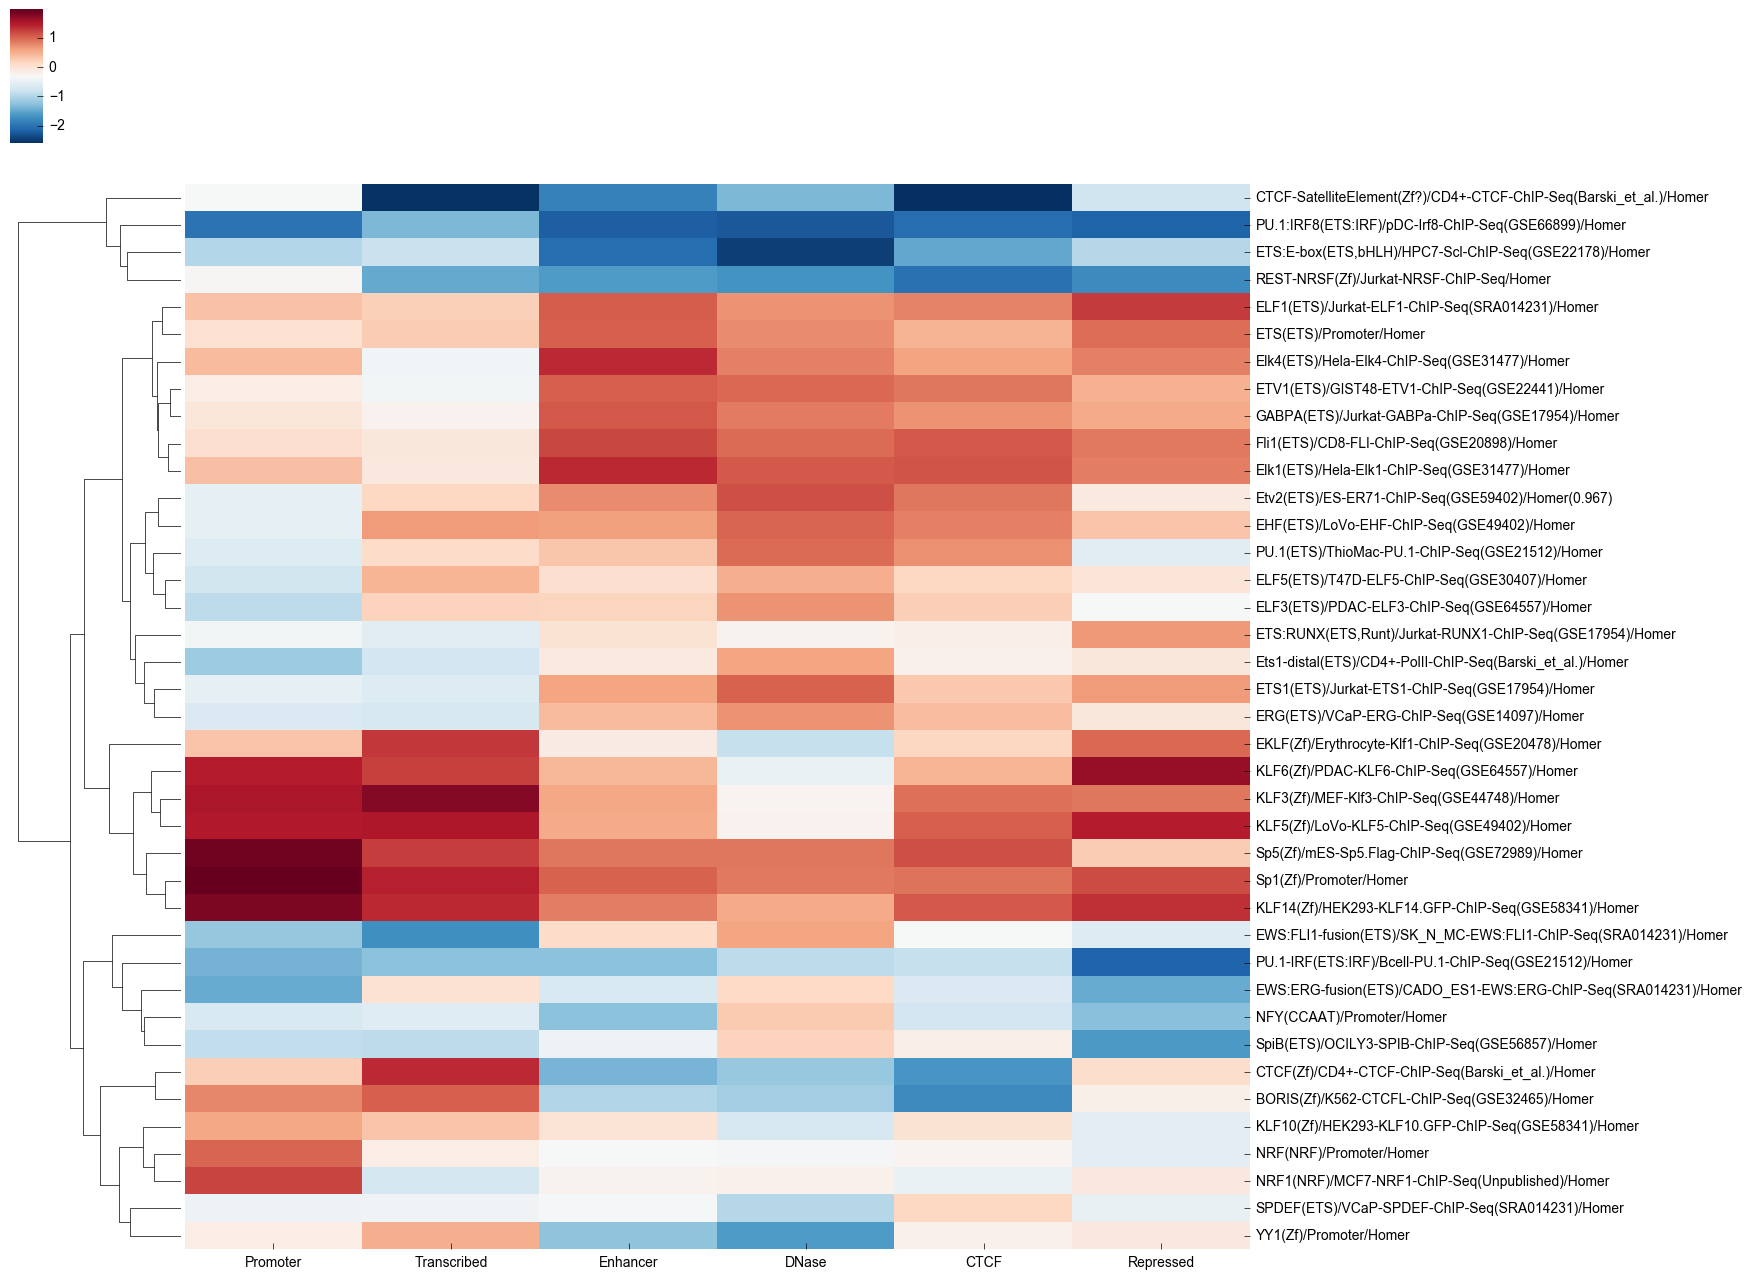

In [241]:
sns.clustermap(deeplift_corr_df,
               cmap = 'RdBu_r',
#                metric = 'correlation',
#                row_linkage = linkage,
#                col_linkage = linkage,
               z_score = 1,
               col_cluster = False,
               row_cluster = True,
#                linewidths=.75, 
               figsize=(16, 16)
              )

plt.show()

## TF-TF co-predictiveness matrix

In [41]:
corr = df.corr(method = 'spearman')

# import matplotlib.pyplot as plt
# import seaborn as sns

# # sns.clustermap(normalizedConvMatrices[0][:10000, :100])
# plt.show()

In [42]:
corr.to_csv("../plots/tfanalysis/tfcorrmatrix_24aug.tab",
              sep = '\t',
#               header = False,
#               index = False
             )

In [75]:
tfShortNames = np.array([tf.split('/')[0] for tf in corr.index])
corr.index = tfShortNames
corr.columns = tfShortNames

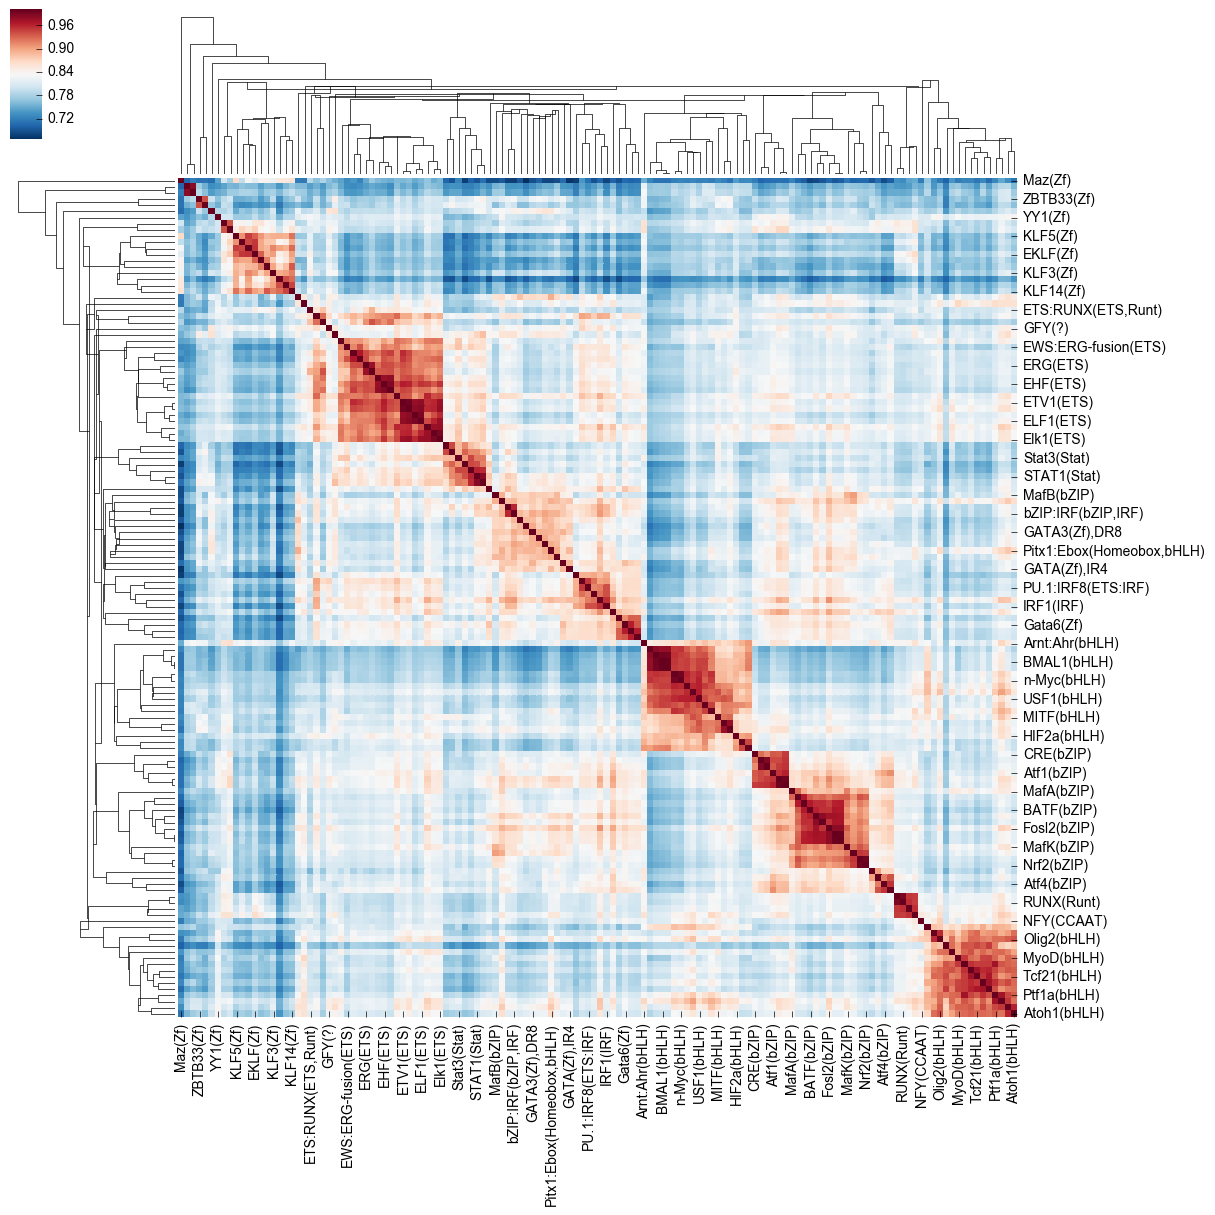

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

corrSubset = corr.iloc[corrMatMotifIdxs, corrMatMotifIdxs]

dist_matrix = 1 - corrSubset
linkage = hc.linkage(sp.distance.squareform(dist_matrix), method='median')

sns.clustermap(corrSubset,
               cmap = 'RdBu_r',
               row_linkage = linkage,
               col_linkage = linkage,
#                z_score = 0,
#                linewidths=.75, 
               figsize=(13, 13)
              )

plt.show()

# Playing around with TF PWM-sequence convolutions

Familiarizing myself with the PWM loading code, playing with scipy's convolve function to make sure we can first just find enriched HOMER motifs.

In [ ]:
import pandas as pd
import numpy as np
import glob
import time

motifpwms = {}

homer_path = '../../data/motifs/homer/*.motif'
t0 = time.time()
for homer_file in glob.glob(homer_path):
    with open(homer_file) as f:
        header = f.readline().strip().split('\t')
        name = header[1]
        threshold = float(header[2])
        weights = np.array(pd.read_csv(f, sep = '\t'))
        motifpwms[name] = weights
print("Took %.3f sec to load HOMER motifs" % (time.time() - t0))
    
# encode_motifs = '../../data/motifs/encode/motifs.txt'
# t0 = time.time()
# with open(encode_motifs) as fp:
#     line = fp.readline().strip()
#     while True:
#         if line == '':
#             break
#         header = line
#         weights = []
#         while True:
#             line = fp.readline()
#             if line == '' or line[0] == '>':
#                 break
#             weights.append(map(float, line.split()[1:]))
#         motifpwms[header] = np.array(weights)
# print("Took %.3f sec to load ENCODE motifs" % (time.time() - t0))

In [ ]:
import h5py

train_data_path = '../hdf5files/sharpr_znormed_jul23/train_data.hdf5'
data = h5py.File(train_data_path)

data_X = np.array(data['X/sequence'])
data_Y = np.array(data['Y/output'])

In [ ]:
from scipy.signal import convolve

motifs = motifpwms.keys()
pwms = np.array([motifpwms[motif].astype(np.float32) for motif in motifs])

conv_matrix = np.ndarray((len(data_X), len(motifs)))
background_conv_matrix = np.ndarray((len(data_X), len(motifs)))

idxs = np.argsort(data_Y[:, 2])[::-1][:500]
bckgrnd_idxs = np.argsort(np.abs(data_Y[:, 2]))[:500]

t0 = time.time()
t1 = time.time()
progress_update = 100
# for (i, seq) in enumerate(data_X):
for (i, idx) in enumerate(np.concatenate((idxs,bckgrnd_idxs))):
#     if i % 31 != 0:
#         continue
    if i > 3000:
        break
    if i % progress_update == 0 and i > 0:
        print("Seqs %d to %d took %.3f sec" % (i - progress_update, i, time.time() - t1))
        t1 = time.time()
    for (j, pwm) in enumerate(pwms):
        if idx in idxs:
            max_conv = np.max(convolve(data_X[idx], pwms[j], mode = 'valid').ravel())
            conv_matrix[idx][j] = max_conv
        elif idx in bckgrnd_idxs:
            max_conv = np.max(convolve(data_X[idx], pwms[j], mode = 'valid').ravel())
            background_conv_matrix[idx][j] = max_conv
        
print("All convolutions took %.3f sec" % (time.time() - t0))

In [ ]:
# print np.sum(conv_matrix, axis = 0)
# print np.sum(background_conv_matrix, axis = 0)
motifScores = np.sum(conv_matrix, axis = 0) / np.sum(background_conv_matrix, axis = 0)
sorted_idxs = np.argsort(motifScores)[::-1]
sortedMotifs = np.array(motifs)[sorted_idxs]
print motifScores[sorted_idxs[:10]]
print sortedMotifs[:10]

## Testing Av's GPU convolution function

In [8]:
import sys
import os
import numpy as np
import modisco
import modisco.util
import time

regions_to_scan = np.array([[
    [[0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0],
     [0.0, 0.0, 0.0, 0.5, 0.4, 0.0, 0.0, 0.0, 0.0],
     [0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.2, 0.0, 0.0],
     [0.0, 0.0, 0.0, 0.0, 0.0, 0.3, 0.0, 0.0, 0.0]]
],[
    [[0.0, 0.0, 0.0, 0.3, 0.0, 0.0, 0.0, 0.0, 0.0],
     [0.0, 0.0, 0.2, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0],
     [0.0, 0.0, 0.0, 0.0, 0.4, 0.5, 0.0, 0.0, 0.0],
     [0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0]]
]]).astype("float32")
filters = np.array([[
    [1.0, 0.0, 1.0, 0.0],
    [2.0, 3.0, 1.0, 0.0],
    [0.0, 0.0, 1.0, 5.0],
    [0.0, 0.0, 0.0, 0.0]
],[
    [0.0, 0.0, 0.0, 0.0],
    [5.0, 1.0, 0.0, 0.0],
    [0.0, 1.0, 3.0, 2.0],
    [0.0, 1.0, 0.0, 1.0]
]]).astype("float32")

scanning_results = np.array(modisco.util.scan_regions_with_filters(
    filters=filters,
    regions_to_scan=regions_to_scan))

print regions_to_scan.shape
print filters.shape
print scanning_results.shape

print(scanning_results)
#fwd scan: [0.5, 1.1, 1.9, 3.7, 1.0, 0.0]
#rev scan: [0.2, 0.3, 0.6, 3.3, 2.9, 0.2]
correct_answer = np.array([[[
                [0.5, 1.1, 1.9, 3.7, 2.9, 0.2],
                [0,   0,   0,   0,   1,   1]
            ],[
                [0.5, 1.1, 1.9, 3.7, 2.9, 0.2],
                [1,   1,   1,   1,   0,   0]
            ],
          ],[
                [[0.2, 2.9, 3.7, 1.9, 1.1, 0.5],
                 [0,   0,   1,   1,   1,   1]],
                [[0.2, 2.9, 3.7, 1.9, 1.1, 0.5],
                 [1,   1,   0,   0,   0,   0]]
          ]])
np.testing.assert_allclose(scanning_results, correct_answer)

Done 0
(2, 1, 4, 9)
(2, 4, 4)
(2, 2, 2, 6)
[[[[ 0.5         1.10000002  1.89999998  3.70000005  2.9000001   0.2       ]
   [ 0.          0.          0.          0.          1.          1.        ]]

  [[ 0.5         1.10000002  1.89999998  3.70000005  2.9000001   0.2       ]
   [ 1.          1.          1.          1.          0.          0.        ]]]


 [[[ 0.2         2.89999986  3.70000005  1.89999998  1.10000002  0.5       ]
   [ 0.          0.          1.          1.          1.          1.        ]]

  [[ 0.2         2.89999986  3.70000005  1.89999998  1.10000002  0.5       ]
   [ 1.          1.          0.          0.          0.          0.        ]]]]
